In [1]:
import numpy as np
import phate
import scprep, scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import pandas as pd
import leidenalg

In [2]:
names = ['GSPA_QR', 'DiffusionEMD', 'MAGIC', 'Signals', 'GSPA', 'GAE_att_Ggene',
       'GAE_noatt_Ggene', 'Node2Vec_Ggene', 'Eigenscore', 'GFMMD', 'SIMBA', 'siVAE']

clist = ['black', 'light yellow', 'mustard', 'teal', 'gray', 'light purple', 'light forest', 'light teal', 'white', 'sienna', 'pink', 'brown']
colors = {'mustard': '#E1AD01', 'berry': '#AC2F3D', 'teal': '#216E76', 'purple':'#502A4F', 'forest': '#065535', 'light forest': '#519167',
          'light yellow': '#E3BC81', 'light berry': '#c7505d', 'light teal': '#81ABA1', 'light purple': '#95636E', 'black': '#000000', 'gray':'#808080', 'white':'white', 'sienna':'sienna', 'pink': 'palevioletred', 'brown':'brown'}

In [4]:
trajectory_data = np.load('../data/splatter_simulated_data.npz')
data = trajectory_data['data']
true_counts = trajectory_data['true_counts']
true_lib_size = true_counts.T.sum(axis=1)

In [4]:
time = trajectory_data['pseudotime'] / 10000

In [6]:
cell_phate_op = phate.PHATE(random_state=1234, verbose=False)
cell_data_phate = cell_phate_op.fit_transform(data)

In [7]:
cell_phate_op = phate.PHATE(random_state=1234, verbose=False)
true_cell_data_phate = cell_phate_op.fit_transform(true_counts)

In [8]:
true_cell_data_phate = true_cell_data_phate * [-1, 1]
cell_data_phate = cell_data_phate * [-1, 1]

## Embeddings for all approaches

2024-06-21 12:48:53,516:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.
2024-06-21 12:48:53,519:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (8821 x 8821) may take some time.
2024-06-21 12:49:35,275:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.
2024-06-21 12:49:35,278:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (8821 x 8821) may take some time.
2024-06-21 12:50:17,220:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compu

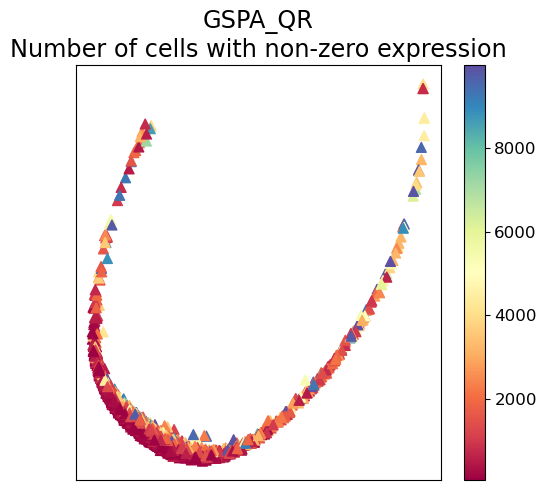

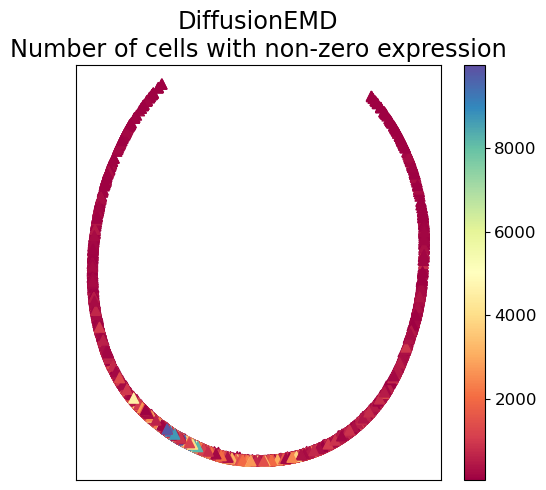

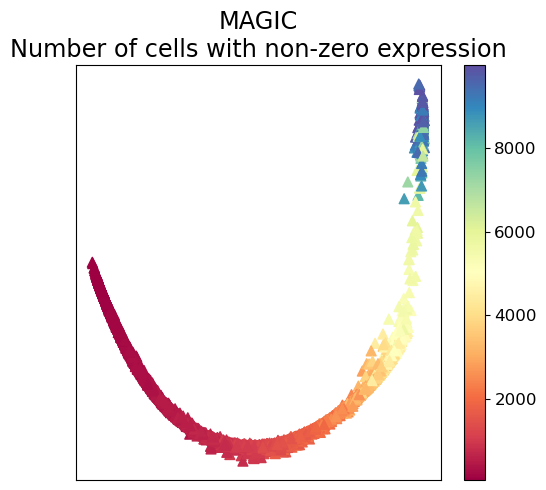

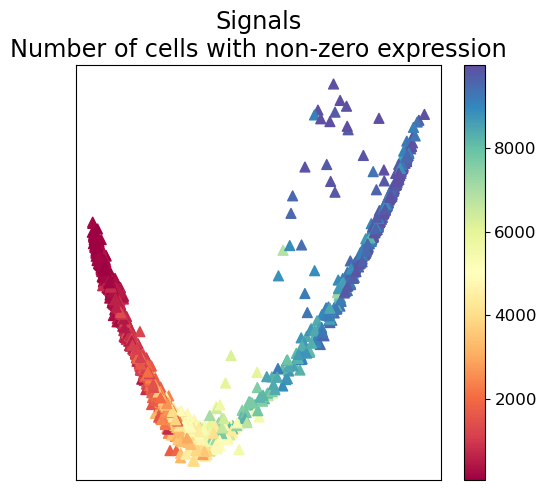

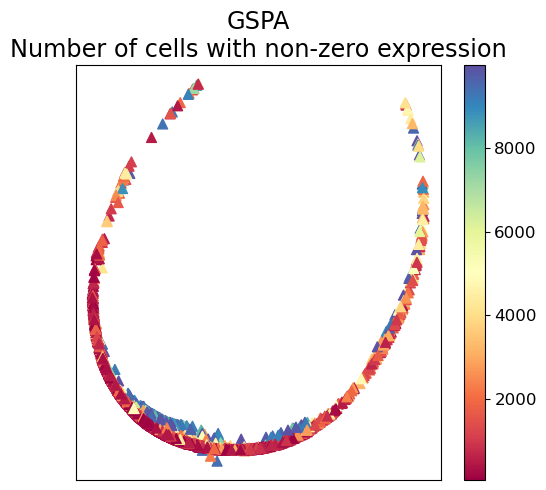

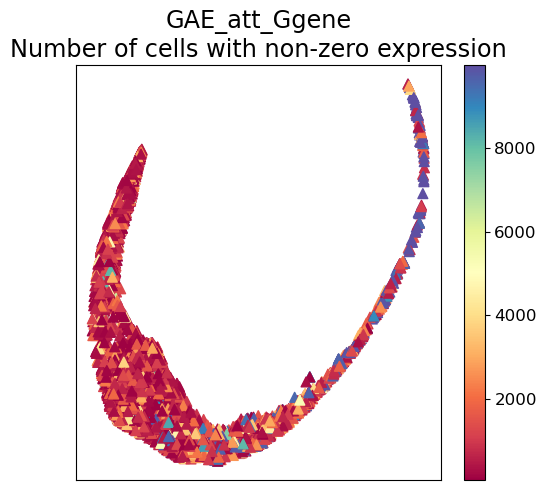

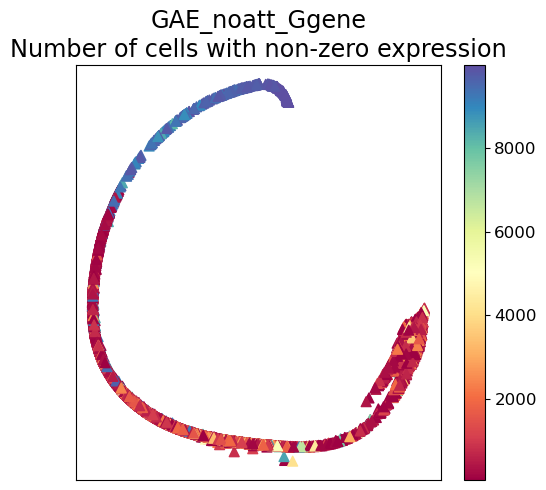

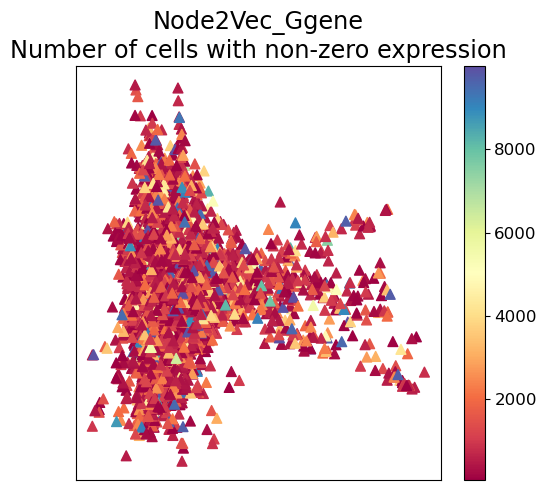

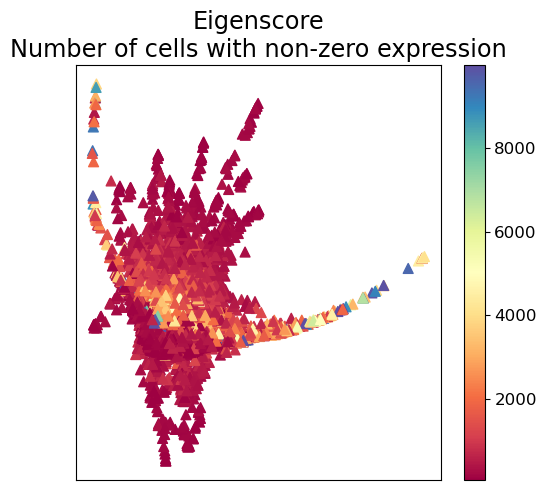

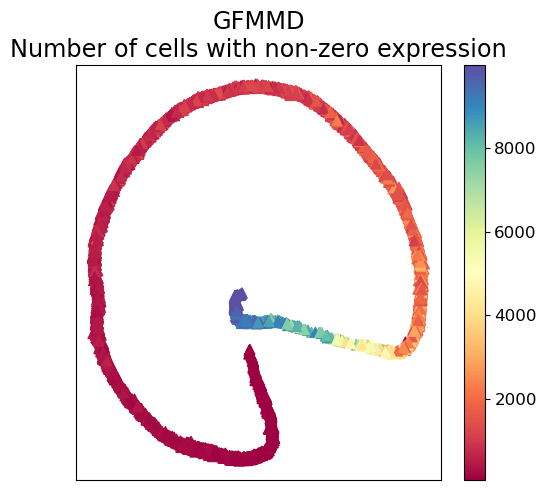

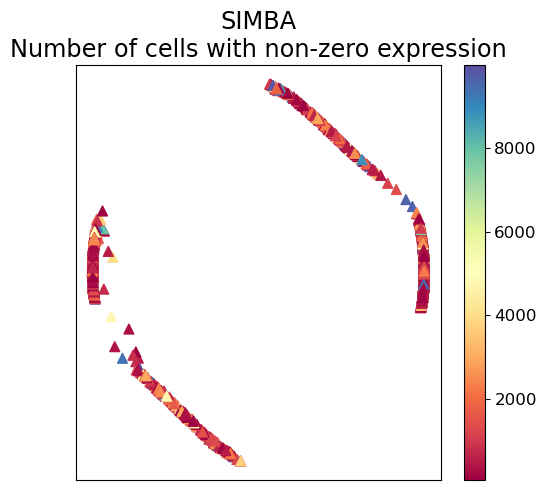

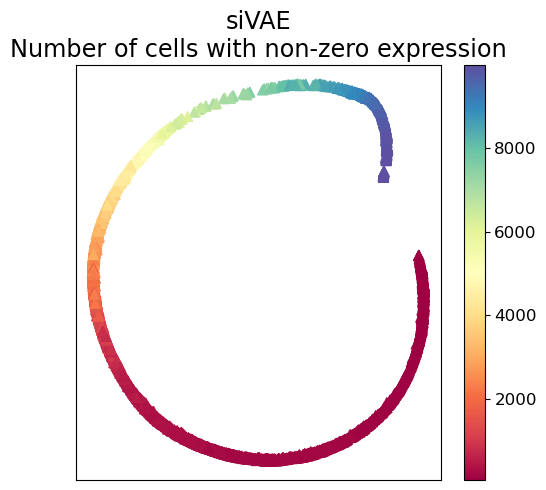

In [5]:
corr_with_fiedler = {}
for method in names:
    results = np.load(f'results/{method}/0_results.npz')
    
    gene_phate_op = phate.PHATE(random_state=1234, verbose=False, use_pygsp=True)
    gene_data_phate = gene_phate_op.fit_transform(results['signal_embedding'])
    fiedler = gene_phate_op.graph.U[:, 1]
    corr_with_fiedler[method] = [pearsonr(fiedler, (data > 0).sum(axis=0)).statistic,
                                 pearsonr(fiedler, data.mean(axis=0)).statistic]

    scprep.plot.scatter2d(gene_data_phate, marker='^',
                      c=(data > 0).sum(axis=0), s=50, ticks=None, figsize=(5,5), cmap='Spectral',
                          title=method + '\nNumber of cells with non-zero expression',
                      filename=f'figures/{method}_num_cells.png', dpi=200, discrete=False)

In [14]:
df = np.abs(pd.DataFrame(corr_with_fiedler)).T.reset_index()
df['color'] = [colors[clist[x]] for x in range(12)]

In [29]:
df

,index,0,1,color
0,GSPA_QR,0.122698,0.103182,#000000
1,DiffusionEMD,0.156525,0.123009,#E3BC81
2,MAGIC,0.966763,0.954102,#E1AD01
3,Signals,0.913622,0.957561,#216E76
4,GSPA,0.118559,0.100404,#808080
5,GAE_att_Ggene,0.381421,0.487804,#95636E
6,GAE_noatt_Ggene,0.549246,0.731747,#519167
7,Node2Vec_Ggene,0.015570,0.016487,#81ABA1
8,Eigenscore,0.109904,0.091374,white
9,GFMMD,0.950845,0.911364,sienna


/tmp/ipykernel_456672/3975740253.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, y='index', x=0, palette=df['color'].tolist(), orient='h')


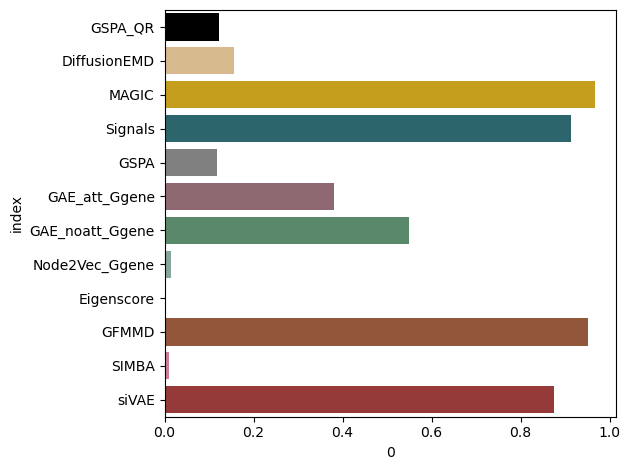

In [33]:
ax = sns.barplot(data=df, y='index', x=0, palette=df['color'].tolist(), orient='h')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('figures/fiedler_corr_with_num_cells_expressed.png', dpi=200)